In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [29]:
# Get the dataset
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [30]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Total number of images in the dataset:",image_count)

Total number of images in the dataset: 3670


In [31]:
batch_size = 32
img_height = 180
img_width = 180

In [32]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [34]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


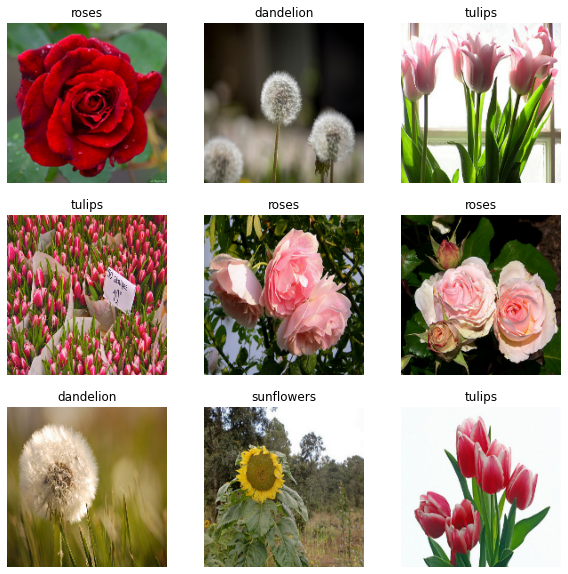

In [35]:
# examples of the images

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [36]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [39]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.9994554


In [40]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

In [43]:
epochs=10
with tf.device('/device:GPU:0'):

  history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
  )

Epoch 1/10
92/92 [==============================] - 3s 32ms/step - loss: 1.3381 - accuracy: 0.4121 - val_loss: 1.0800 - val_accuracy: 0.5395
Epoch 2/10
92/92 [==============================] - 2s 20ms/step - loss: 0.9972 - accuracy: 0.5988 - val_loss: 1.0099 - val_accuracy: 0.6226
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.8133 - accuracy: 0.7006 - val_loss: 0.9099 - val_accuracy: 0.6608
Epoch 4/10
92/92 [==============================] - 2s 20ms/step - loss: 0.6108 - accuracy: 0.7776 - val_loss: 0.9447 - val_accuracy: 0.6662
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.4126 - accuracy: 0.8512 - val_loss: 1.1959 - val_accuracy: 0.6131
Epoch 6/10
92/92 [==============================] - 2s 20ms/step - loss: 0.2444 - accuracy: 0.9149 - val_loss: 1.3383 - val_accuracy: 0.6417
Epoch 7/10
92/92 [==============================] - 2s 20ms/step - loss: 0.1500 - accuracy: 0.9564 - val_loss: 1.5712 - val_accuracy: 0.6349
Epoch 8/10
92

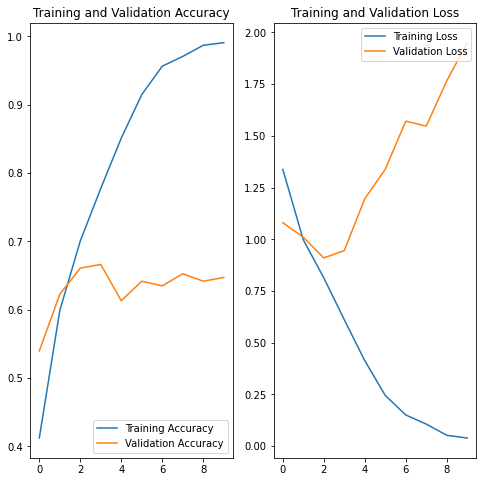

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 99.55 percent confidence.


Now we try to do our Lime explaination

In [46]:
try:
  import lime
except:
  !pip install lime
from lime import lime_image
import os,sys

In [47]:
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread


In [48]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = keras.preprocessing.image.load_img(img_path, target_size=(180, 180))
        x = keras.preprocessing.image.img_to_array(img)
        x = tf.expand_dims(x, 0)
        # x = model.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

This image most likely belongs to roses with a 100.00 percent confidence.


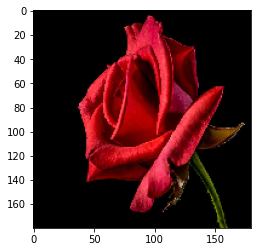

In [49]:
#You can use your own image and change the variable filename to the picture's name
filename='redrose.jpg'
images1 = transform_img_fn([os.path.join('/content/',filename)])

plt.imshow(images1[0].astype("uint8"))
preds= model.predict(images1)


score = tf.nn.softmax(preds[0])
p=model.predict(images1)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)



In [50]:
explainer = lime_image.LimeImageExplainer()

In [51]:
explanation = explainer.explain_instance(images1[0].astype('double'), model.predict, top_labels=5, hide_color=0)

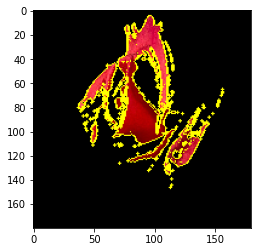

In [52]:
#Show only parts that contributed positively and hide the rest of picture
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, hide_rest=True)
plt.imshow(mark_boundaries(temp.astype("uint8"), mask))

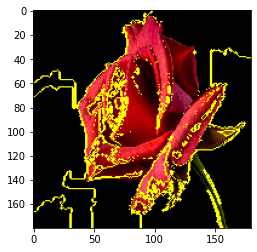

In [53]:
#Show only parts that contributed positively and more superpixels(features). Shows all the picture
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=1000, hide_rest=False)
plt.imshow(mark_boundaries(temp.astype("uint8"), mask))

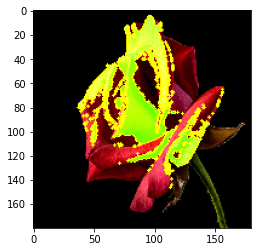

In [54]:
#Show both positive and negative
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, hide_rest=False)
plt.imshow(mark_boundaries(temp.astype("uint8"), mask))

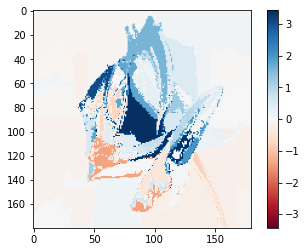

In [55]:
#Show the weight distribution of explanation using heatmap
ind =  explanation.top_labels[0]


dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 


plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()